# Loading the data

Here we are going to use a popular Kaggle dataset: [Wine Reviews](https://www.kaggle.com/zynicide/wine-reviews)

In [ ]:
# download the data from Kaggle and then run this cell to upload the downloaded data
from google.colab import files
uploaded = files.upload()

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
df = pd.read_csv("winemag-data-130k-v2.csv").iloc[:, 1:]
df.sample(10)

country  ...                           winery
102816  Austria  ...                            Malat
109630       US  ...                    Mission Trail
60990     Italy  ...  Baglio del Cristo di Campobello
113557    Chile  ...              Luis Felipe Edwards
31073     Italy  ...                         Majolini
58538     Italy  ...                         Giordano
88544        US  ...                 Cycles Gladiator
65810        US  ...                           DanCin
9874         US  ...                       Wellington
58502    France  ...       Jean-Luc and Paul Aegerter

[10 rows x 13 columns]

# Describing our data

A typical way of getting a high-level summary of a dataframe is by using [pandas.DataFrame.describe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html)

In [ ]:
df.describe(include='all')

country  ...              winery
count   129908  ...              129971
unique      43  ...               16757
top         US  ...  Wines & Winemakers
freq     54504  ...                 222
mean       NaN  ...                 NaN
std        NaN  ...                 NaN
min        NaN  ...                 NaN
25%        NaN  ...                 NaN
50%        NaN  ...                 NaN
75%        NaN  ...                 NaN
max        NaN  ...                 NaN

[11 rows x 13 columns]

We can use [pandas-profiling](https://github.com/pandas-profiling/pandas-profiling) to generate a more comprehensive report

In [ ]:
# need to install the latest version, otherwise not compatible with Pandas v1.0 and above
!pip install pandas-profiling==2.8.0

In [ ]:
from pandas_profiling import ProfileReport
ProfileReport(df)

# Define our Goal

This is the step that we usually ignore - but actually very crucial. Data cleaning can be very open-ended and we may spend our valuable time that doesn't yield anything at all.

For the scope of the demo, we can set this simple goal: predict `points` from other columns. We can first check the overall distribution of the `points` data.

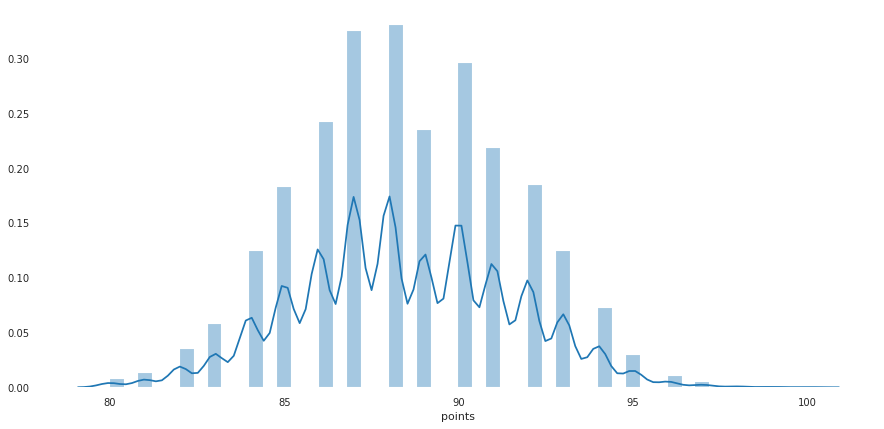

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,7))
sns.distplot(df["points"]);

The values for column `points` range between 80-100 (inclusive) and the above plot shows that the data is likely to be normally distributed (no obvious outliers) - this is a nice start.

# Data Cleaning

Given the awesome data profiling result, we can start cleaning the data step-by-step towards the direction of our goal.

## Removing duplicates

The report shows that the data set has 9983 duplicate rows, or about 7% of the data. 

**WARNING**: *We need to make sure duplicate records are NOT acceptable in the context of each dataset. For instance, duplicates are acceptable in the following data because each row corresponds to different transaction*

| Product name  | Quantity |
| ----------- | ----------- |
| White bread   | 1       |
| Chocolate bar | 3       |
| White bread   | 1       |



We can remove duplicate rows by using [pandas.DataFrame.drop_duplicates](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html)

In [ ]:
# always use a new variable to represent the new dataframe
#    df = df.drop_duplicates() => DO NOT DO THIS
df_no_duplicates = df.drop_duplicates()

ProfileReport(df_no_duplicates)

## Removing unnecessary columns

In the context of prediction, we can remove columns who either
- has categorial values with many distinct count (let's say above 300) 
- has a lot of missing values (let's say above 30%)

In [ ]:
from pandas.api.types import is_numeric_dtype

# feel free to change these numbers
THRESHOLD_DISCTINCT_COUNT = 300
THRESHOLD_MISSING_VALUES = 30/100 # this corresponds to 30%

def has_high_count(df: pd.DataFrame, column: str) -> bool:
   col = df[column]
   return not is_numeric_dtype(col) and col.nunique() > THRESHOLD_DISCTINCT_COUNT

def has_many_missing_values(df: pd.DataFrame, column: str) -> bool:
  num_of_missing_values = df[column].isnull().sum()
  return num_of_missing_values/len(df) > THRESHOLD_MISSING_VALUES

def get_columns_to_remove(df: pd.DataFrame) -> list:
  column_with_high_distinct_count = [c for c in df.columns if has_high_count(df, c)]
  column_with_many_missing_values = [c for c in df.columns if has_many_missing_values(df, c)]
  result = set(column_with_high_distinct_count + column_with_many_missing_values)
  
  print(f"High distinct count: {column_with_high_distinct_count}")
  print(f"Many missing values: {column_with_many_missing_values}")
  print(f"Columns to remove: {result}")

  return result

columns_to_remove = get_columns_to_remove(df_no_duplicates)

High distinct count: ['description', 'designation', 'province', 'region_1', 'title', 'variety', 'winery']
Many missing values: ['region_2']
Columns to remove: {'description', 'winery', 'province', 'title', 'region_2', 'region_1', 'designation', 'variety'}


We can then use [pandas.DataFrame.drop](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html) to remove 1 or more columns from a given dataframe.

In [ ]:
df_after_removing_columns = df_no_duplicates.drop(
    # columns to ignore
    columns_to_remove,
    # default is 0 for dropping rows, 1 is for columns
    axis = 1
)

ProfileReport(df_after_removing_columns)

Note that `price` is not removed even though it has more than 300 distinct count - because it is a **numeric column**. In the context of making a prediction

## Dealing with Missing Data and Outliers

Next we focus on dealing with missing data and outliers. From the above report, we see that the following columns with missing data
- `taster_twitter_handle` (24.5%)
- `taster_name` (20.8%)
- `price` (7%)
- `country` (< 0.1%, 59 records)


Let's create some helper methods in regards to these missing columns.



In [ ]:
# view rows where a given column has missing values
def get_null_values(df: pd.DataFrame, column: str) -> pd.DataFrame:
  return df[df[column].isnull()]

def get_segmented_boxplot(df: pd.DataFrame, column: str):
  plt.figure(figsize=(20,5))
  sns.boxplot(x='points', y=column, data=df)

According to the latest profiling, each of this column has relatively small number of unique values (19 and 15 respectively) from ~120k records. 

In [ ]:
get_null_values(df_after_removing_columns, 'taster_twitter_handle').sample(5)

country  points  price         taster_name taster_twitter_handle
52581  Germany      86   12.0  Anna Lee C. Iijima                   NaN
2939        US      84   23.0                 NaN                   NaN
97519    Italy      88    NaN                 NaN                   NaN
20046  Germany      91   25.0  Anna Lee C. Iijima                   NaN
7148        US      84   36.0                 NaN                   NaN

In [ ]:
get_null_values(df_after_removing_columns, 'taster_name').sample(5)

country  points  price taster_name taster_twitter_handle
109224      US      80   22.0         NaN                   NaN
60348       US      89   50.0         NaN                   NaN
129604      US      84   58.0         NaN                   NaN
60873    Italy      81   16.0         NaN                   NaN
90751       US      91   22.0         NaN                   NaN

For the sake of simplicity, let's say we do not care about those records that do not specify `taster_name`. And, we also want to remove `taster_twitter_hande` as it should be closely connected to the identity specified in `taster_name`.

In [ ]:
df_with_taster = df_after_removing_columns.drop("taster_twitter_handle", axis=1)
df_with_taster = df_with_taster[~df_with_taster["taster_name"].isnull()]

ProfileReport(df_with_taster)

From the profiling of the `price` column, we see it:
- is a numeric column
- has many distinct count (300+)
- has some bad outliers (see below)

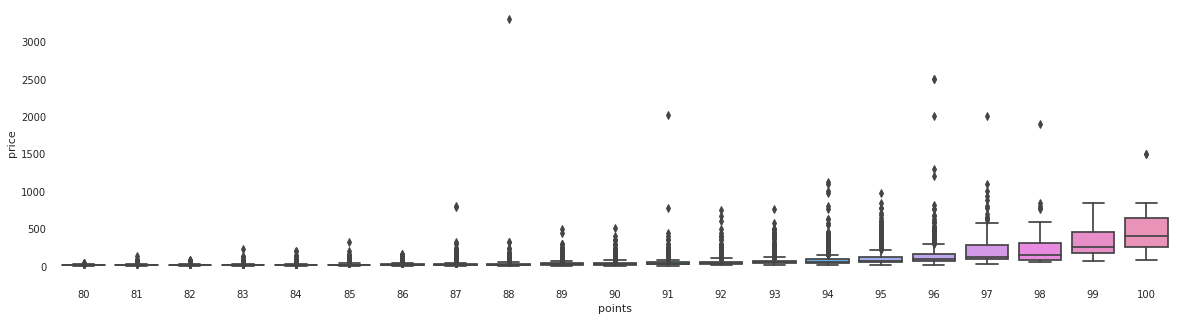

In [ ]:
get_segmented_boxplot(df_with_taster, 'price')

Due to these outliers, we can do several things:
- replace null values with median
- replace some of the outliers 
- scale the values between 0 and 1 (using [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html))



In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

imp_median = SimpleImputer(strategy='median')
scaler = MinMaxScaler()

NUMERIC_COLUMN = "price"

def replace_with_median(df: pd.DataFrame, column: str=NUMERIC_COLUMN):
  df[column] = imp_median.fit_transform(df[[column]])

def scale_data(df: pd.DataFrame, column: str=NUMERIC_COLUMN):
  df[column] = scaler.fit_transform(df[[column]])

df_after_deal_with_missing_and_outliers = df_with_taster.copy()
replace_with_median(df_after_deal_with_missing_and_outliers)
scale_data(df_after_deal_with_missing_and_outliers)

ProfileReport(df_after_deal_with_missing_and_outliers)

## Dealing with categorical data

As of now, we have 3 categorical columns (`country, taster_twitter_handle, taster_name`) and 1 numeric column (`price`) left. To be used for prediction algorithms, all columns must be converted to numerical ones. 

[Scikit-Learn](https://scikit-learn.org/stable/index.html) provides a good solution using [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) to encode categorical data to numerical data. Note that this requires the data

In [ ]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(df_after_deal_with_missing_and_outliers[['taster_name']])

encoded_taster_name =enc.transform(df_after_deal_with_missing_and_outliers[['taster_name']]).toarray()

In [ ]:
df_after_deal_with_missing_and_outliers.index = range(0,95071)

df_after_transforming_categorical = pd.DataFrame(encoded_taster_name)
df_after_transforming_categorical[["price", "points"]] = df_after_deal_with_missing_and_outliers[["price", "points"]].copy()

ProfileReport(df_after_transforming_categorical)

# df_after_transforming_categorical["
# df_after_deal_with_missing_and_outliers["price"]

In [ ]:
df_preprocessed = df_after_transforming_categorical.copy()

# Making Simple Prediction

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
predictors = df_preprocessed.drop("points", axis=1)
target = df_preprocessed["points"]

X_train, X_test, y_train, y_test = train_test_split(
    predictors, target, 
    # set 20% as testing data
    test_size=0.20, 
    # make a habit of setting this, final result will be the same if re-run with the same value
    random_state=42
)

lr.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
result = pd.DataFrame(
    {
        "exp": y_test,
        "est": lr.predict(X_test)
    }
)

result["diff"] = (result["exp"]-result["est"]).abs()

result

exp  est  diff
88477   92   90     2
15480   90   88     2
51170   88   87     1
15294   88   88     0
27779   91   90     1
...    ...  ...   ...
12994   92   88     4
25173   89   90     1
51418   87   87     0
58474   91   88     3
26700   85   88     3

[19015 rows x 3 columns]

In [ ]:
original_mean = np.mean(result['exp'])
baseline_abs_error = np.mean((original_mean - result["exp"]).abs())

f"Baseline error {baseline}"

'Baseline average 2.470496208585759'

In [ ]:
f"Mean absolute error is {np.mean(result['diff'])}"

'Mean absolute error is 2.2579542466473836'

In [ ]:
baseline_mse = np.sqrt(np.mean((original_mean - result["exp"])**2))

f"Baseline MSE {baseline_mse}"

'Baseline MSE 3.017566636023511'

In [ ]:
from sklearn.metrics import mean_squared_error

rms = np.sqrt(mean_squared_error(result["exp"], result["est"]))

f"Mean squared error is {rms}"

'Mean squared error is 2.8510116024855514'